In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../src')

In [4]:
import torch
import scipy.sparse as sp


In [5]:
# %%time

# torch.concat([torch.sparse.mm(gex, gg).to_dense() for _ in range(6000)], dim=0).shape

In [6]:
import spaceoracle
from spaceoracle.models.estimators import ViTEstimatorV2

In [7]:
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch

In [8]:
adata_train = anndata.read_h5ad('../data/slideseq/day3_1.h5ad')
adata_test = anndata.read_h5ad('../data/slideseq/day3_2.h5ad')

In [9]:
n_top_genes = 1000
min_cells = 10
min_counts = 350

adata_train.var_names_make_unique()
adata_train.var["mt"] = adata_train.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_train, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata_train, min_counts=min_counts)
adata_train = adata_train[adata_train.obs["pct_counts_mt"] < 20].copy()
adata_train = adata_train[:, ~adata_train.var["mt"]]
sc.pp.filter_genes(adata_train, min_cells=min_cells)

adata_train.layers["raw_count"] = adata_train.X

sc.pp.normalize_total(adata_train, inplace=True)
sc.pp.log1p(adata_train)
sc.pp.highly_variable_genes(
    adata_train, flavor="seurat", n_top_genes=n_top_genes)

adata_train = adata_train[:, adata_train.var.highly_variable]
adata_train

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


View of AnnData object with n_obs × n_vars = 9043 × 1000
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [10]:
adata_test.var_names_make_unique()
adata_test.var["mt"] = adata_test.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_test, qc_vars=["mt"], inplace=True)
sc.pp.filter_cells(adata_test, min_counts=min_counts)
adata_test = adata_test[adata_test.obs["pct_counts_mt"] < 20].copy()
adata_test = adata_test[:, ~adata_test.var["mt"]]
sc.pp.filter_genes(adata_test, min_cells=min_cells)

adata_test.layers["raw_count"] = adata_test.X

sc.pp.normalize_total(adata_test, inplace=True)
sc.pp.log1p(adata_test)
sc.pp.highly_variable_genes(
    adata_test, flavor="seurat", n_top_genes=n_top_genes)

adata_test = adata_test[:, adata_test.var.highly_variable]
adata_test

View of AnnData object with n_obs × n_vars = 11411 × 1000
    obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'raw_count'

In [11]:
np.intersect1d(adata_train.var_names, adata_test.var_names).__len__()

227

In [12]:
adata_train = adata_train[:, adata_train.var_names.isin(np.intersect1d(adata_train.var_names, adata_test.var_names))]
adata_test = adata_test[:, adata_test.var_names.isin(np.intersect1d(adata_train.var_names, adata_test.var_names))]

adata_train, adata_test

(View of AnnData object with n_obs × n_vars = 9043 × 227
     obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'cluster_colors', 'rctd_cluster_colors', 'log1p', 'hvg'
     obsm: 'X_spatial', 'rctd_results', 'spatial'
     layers: 'raw_count',
 View of AnnData object with n_obs × n_vars = 11411 × 227
     obs: 'cluster', 'rctd_cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', '

In [13]:
np.intersect1d(adata_train.var_names, adata_test.var_names).__len__()

227

In [14]:
from pympler.asizeof import asizeof
sz = lambda x: f'{asizeof(x) / (1024*1024):.4g} MB'

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [17]:
import shutil
import os
    
models_dir = './models'
if os.path.exists(models_dir):
    shutil.rmtree(models_dir)
os.makedirs(models_dir)

In [18]:
%%time

so = spaceoracle.SpaceOracle(
    adata_train, 
    init_betas='ones', 
    spatial_dim=32,
    max_epochs=0, 
    learning_rate=3e-2
)

🌍️ Generating spatial maps: 100%|██████████| 9043/9043 [00:01<00:00, 4738.80it/s]


CPU times: user 31.4 s, sys: 8.83 s, total: 40.3 s
Wall time: 46.3 s


In [23]:
coef_matrix = so.get_coef_matrix(so.adata.copy())

100%|██████████| 127/127 [00:50<00:00,  2.52it/s]


In [29]:
coef_matrix

tensor(indices=tensor([[  20,   20,   20,  ...,  198,  198,  198],
                       [   0,    0,    0,  ...,  224,  224,  224],
                       [   0,    1,    2,  ..., 9040, 9041, 9042]]),
       values=tensor([-0.0250, -0.0250, -0.0250,  ..., -0.2238, -0.2238,
                      -0.2237]),
       size=(227, 227, 9043), nnz=2568212, layout=torch.sparse_coo)

In [59]:
perturbed_matrix = so.perturb(so.adata.to_df().values, coef_matrix, n_propagation=3)

100%|██████████| 9043/9043 [00:08<00:00, 1066.60it/s]

(9043, 227) (9043, 227)


TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

In [50]:
perturbed_matrix.shape

(9043, 227)

In [56]:
np.where(perturbed_matrix != 0)

(array([ 796, 2948, 5816, 6413, 6533, 7887]),
 array([188,   6,  66, 192,  81, 185]))

In [54]:
perturbed_matrix[:, 74].sum()

0.0

In [52]:
so.adata.to_df().values[:, 46].sum()

7929.6484

In [41]:
list(so.adata.var_names).index('Cd74')

46

In [21]:
from sklearn.linear_model import Ridge
from tqdm import tqdm
import pandas as pd
import celloracle as co
oracle = co.data.load_tutorial_oracle_object()

def _getCoefMatrix(alpha=1, verbose=True):

    gem = adata_train.to_df()

    # TFdict = dict(
    #     zip(so.grn.get_regulators(adata_train, 'Cd74'),
    #     [so.grn.get_targets(adata_train, x) for x in so.grn.get_regulators(adata_train, 'Cd74')])
    # )
    
    TFdict = oracle.TFdict

    genes = gem.columns

    all_genes_in_dict = intersect(gem.columns, list(TFdict.keys()))
    zero_ = pd.Series(np.zeros(len(genes)), index=genes)

    def get_coef(target_gene):
        tmp = zero_.copy()

        # define regGenes
        reggenes = TFdict[target_gene]
        reggenes = intersect(reggenes, genes)


        if target_gene in reggenes:
            reggenes.remove(target_gene)
        if len(reggenes) == 0 :
            tmp[target_gene] = 0
            return(tmp)
        # prepare learning data
        Data = gem[reggenes]
        Label = gem[target_gene]
        # model fitting
        model = Ridge(alpha=alpha, random_state=123)
        model.fit(Data, Label)
        tmp[reggenes] = model.coef_

        return tmp

    li = []
    li_calculated = []
    with tqdm(genes) as pbar:
        for i in pbar:
            if not i in all_genes_in_dict:
                tmp = zero_.copy()
                tmp[i] = 0
            else:
                tmp = get_coef(i)
                li_calculated.append(i)
            li.append(tmp)
    coef_matrix = pd.concat(li, axis=1)
    coef_matrix.columns = genes

    if verbose:
        print(f"genes_in_gem: {gem.shape[1]}")
        print(f"models made for {len(li_calculated)} genes")

    return coef_matrix #, li_calculated

def intersect(list1, list2):
    inter_list = list(set(list1).intersection(list2))
    return(inter_list)

/Users/koush/Projects/SpaceOracle/notebooks/../src/celloracle/utility/hdf5_processing.py:41: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  return pickle.loads(zlib.decompress(uint.tobytes()))
/Users/koush/Projects/SpaceOracle/notebooks/../src/celloracle/utility/hdf5_processing.py:41: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  return pickle.loads(zlib.decompress(uint.tobytes()))
/Users/koush/Projects/SpaceOracle/notebooks/../src/celloracle/utility/hdf5_processing.py:41: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  return pickle.loads(zlib.decompress(uint.tobytes()))


In [22]:
coef = _getCoefMatrix()

100%|██████████| 227/227 [00:00<00:00, 747.75it/s]

genes_in_gem: 227
models made for 179 genes


In [23]:
adata_train.shape, coef.shape

((9043, 227), (227, 227))

In [121]:
coef['Cd74'][coef['Cd74'] != 0]

Bcl11a    0.433579
Ebf3     -0.005962
Name: Cd74, dtype: float64

In [32]:
gem = adata_train.to_df()
TFdict = oracle.TFdict
genes = gem.columns
all_genes_in_dict = intersect(gem.columns, list(TFdict.keys()))
zero_ = pd.Series(np.zeros(len(genes)), index=genes)

In [33]:
tmp = zero_.copy()
target_gene = 'Cd74'

# define regGenes
reggenes = TFdict[target_gene]
reggenes = intersect(reggenes, genes)


if target_gene in reggenes:
    reggenes.remove(target_gene)

print(len(reggenes))


2


In [38]:
Data = gem[reggenes]
Label = gem[target_gene]
# model fitting
model = Ridge(alpha=0, random_state=123)
model.fit(Data, Label)
model.coef_

array([-0.00654467,  0.43451774], dtype=float32)

In [64]:
so.adata.shape

(9043, 227)

In [290]:
def update_sparse_tensor(sparse_tensor, oracle_output):

    for k in range(len(oracle_output.regulators_index)):
        indices = torch.tensor(
            [[
                oracle_output.regulators_index[k], 
                oracle_output.target_gene_index, i] 
                    for i in range(so.adata.shape[0])
            ], dtype=torch.long)

        values = oracle_output.betas[:, k+1]
        new_sparse_tensor = torch.sparse_coo_tensor(indices.t(), values, sparse_tensor.size())
        sparse_tensor = sparse_tensor + new_sparse_tensor

    return sparse_tensor


In [291]:
num_genes = len(so.adata.var_names)
indices = torch.empty((3, 0), dtype=torch.long)
values = torch.empty(0)
sparse_tensor = torch.sparse_coo_tensor(
    indices, values, (num_genes, num_genes, so.adata.shape[0]))

for gene in tqdm(so.trained_genes):
    r = so._get_betas(so.adata, gene)
    sparse_tensor = update_sparse_tensor(sparse_tensor, r)

100%|██████████| 127/127 [00:48<00:00,  2.61it/s]


In [360]:
# Convert adata.X to sparse tensor
import scipy.sparse as sp

# Check if adata.X is already a sparse matrix
if sp.issparse(so.adata.X):
    # If it's sparse, convert to COO format (if not already) and then to torch sparse tensor
    coo = so.adata.X.tocoo()
    values = torch.FloatTensor(coo.data)
    indices = torch.LongTensor(np.vstack((coo.row, coo.col)))
    shape = coo.shape
    adata_sparse_tensor = torch.sparse_coo_tensor(indices, values, torch.Size(shape))
else:
    # If it's dense, convert to torch sparse tensor directly
    adata_sparse_tensor = torch.sparse_coo_tensor(
        indices=torch.nonzero(torch.tensor(so.adata.X)).t(),
        values=torch.tensor(so.adata.X)[torch.nonzero(torch.tensor(so.adata.X), as_tuple=True)],
        size=so.adata.X.shape
    )

print(f"Converted adata.X to sparse tensor with shape: {adata_sparse_tensor.shape}")

Converted adata.X to sparse tensor with shape: torch.Size([9043, 227])


In [381]:
torch.from_numpy(so.adata.to_df().values)[0].shape, sparse_tensor[..., 0].shape

(torch.Size([227]), torch.Size([227, 227]))

In [396]:
torch.concat([torch.sparse.mm(
    sparse_tensor[..., i], 
    torch.from_numpy(so.adata.to_df().values)[i].view(227, 1)
) for i in tqdm(range(so.adata.shape[0]))], dim=1).shape

100%|██████████| 9043/9043 [00:14<00:00, 630.04it/s]


torch.Size([227, 9043])

In [344]:
coef2 = pd.DataFrame(
    sparse_tensor.to_dense()[:, :, 0], 
    index=so.adata.var_names[:], 
    columns=so.adata.var_names
)

In [345]:
np.where(coef2 != 0)[1].shape

(284,)

In [346]:
np.unique(np.where(coef2 != 0)[0])

array([ 20,  74,  88, 146, 161, 164, 198])

In [298]:
so.trained_genes.__len__()

127

In [304]:
coef2['Cd74'][coef2['Cd74'] != 0]

Bcl11a   -0.009919
Ebf3     -0.195362
Name: Cd74, dtype: float32

In [310]:
coef2.loc['Bcl11a']['Cd74']

-0.009919271

-0.2052812

In [178]:
so.adata.var_names.shape, sparse_tensor.shape

((227,), torch.Size([227, 227, 101]))

In [180]:
np.where(coef2 != 0)

(array([46, 46]), array([20, 74]))

In [181]:
coef2.columns[46]

'Cd74'

In [98]:
sparse_tensor[46][74]

tensor(indices=tensor([[   0,    1,    2,  ..., 9040, 9041, 9042]]),
       values=tensor([-0.1954, -0.1954, -0.1954,  ..., -0.1954, -0.1954,
                      -0.1954]),
       size=(9043,), nnz=9043, layout=torch.sparse_coo)

In [17]:
# print(f"{'Key':<30} {'Type':<30} {'Size':<30}")
# print("-" * 75)
# print(f"{'SpaceOracle':<30} {type(so).__name__:<30} {sz(so):<30}\n")

# for k, v in so.__dict__.items():
#     print(f"{k:<30} {type(v).__name__:<30} {sz(v):<30}")
#     if isinstance(v, anndata.AnnData):
#         for kj in v.obsm:
#             if type(v.obsm[kj]) == np.ndarray:
#                 print(f"  {kj:<30} {type(v.obsm[kj]).__name__+f'{v.obsm[kj].shape}':<30} {sz(v.obsm[kj]):<30}")
#             else:
#                 print(f"  {kj:<30} {type(v.obsm[kj]).__name__:<30} {sz(v.obsm[kj]):<30}")
#         print()

In [25]:
from tqdm import tqdm
from spaceoracle.models.estimators import device

In [151]:
gene_by_gene_tf = pd.DataFrame(columns=so.trained_genes, index=so.trained_genes)


In [164]:
sz(np.array([pd.DataFrame(columns=so.trained_genes, index=so.trained_genes).values]*10000))

In [141]:
%%time

regulators = []

gene_by_gene_tf = pd.DataFrame(columns=so.trained_genes, index=so.trained_genes)

with torch.no_grad():
    for tg in tqdm(so.trained_genes):
        loaded_dict = so.load_estimator(tg)
        out = loaded_dict['model'].forward(
            torch.from_numpy(so.adata.obsm['spatial_maps'][:, ...]).float().to(device),
            torch.from_numpy(np.array(adata_train.obs['rctd_cluster'])[:, ...]).long().to(device)
        )

        _zero[loaded_dict['regulators']] = out[:, 1:].cpu().numpy()

        regulators.append(loaded_dict['regulators'])

 60%|██████    | 574/949 [03:14<02:06,  2.95it/s]


KeyboardInterrupt: 

In [142]:
_zero = pd.Series(np.zeros(len(so.trained_genes)), index=so.trained_genes)

In [144]:
_zero[loaded_dict['regulators']]

Atf3      0.0
Bcl11a    0.0
Brf1      0.0
Ebf1      0.0
Erg       0.0
Hdac2     0.0
Irf7      0.0
Klf7      0.0
Mef2a     0.0
Mef2c     0.0
Nfatc4    0.0
Nr1d2     0.0
Pax5      0.0
Rreb1     0.0
Rxra      0.0
Taf1      0.0
Tcf7l2    0.0
dtype: float64

In [150]:
so._get_betas(
    so.adata,
    'Cd74'
)

AttributeError: 'SpaceOracle' object has no attribute '_get_betas'

In [36]:
r1[1].shape, len(regulators[1])

((9043, 31), 30)

In [38]:
import pandas as pd

In [40]:
r1[0][:, 1:].shape

(9043, 26)

In [42]:
pd.DataFrame(r1[0][:, 1:], columns=regulators[0])

Atf3    Bcl11a      Brf1      Ebf1       Erg     Fosl2     Hdac2  \
0    -0.125975 -0.111229  0.123534 -0.304182 -0.278736 -0.073320  0.002906   
1    -0.125966 -0.111236  0.123529 -0.304178 -0.278757 -0.073334  0.002898   
2    -0.125973 -0.111252  0.123536 -0.304202 -0.278775 -0.073330  0.002887   
3    -0.125963 -0.111234  0.123538 -0.304193 -0.278770 -0.073331  0.002912   
4    -0.125966 -0.111227  0.123542 -0.304191 -0.278744 -0.073322  0.002919   
...        ...       ...       ...       ...       ...       ...       ...   
9038 -0.125969 -0.111227  0.123555 -0.304193 -0.278737 -0.073322  0.002918   
9039 -0.125968 -0.111247  0.123529 -0.304197 -0.278751 -0.073314  0.002903   
9040 -0.125976 -0.111246  0.123488 -0.304168 -0.278817 -0.073367  0.002858   
9041 -0.125988 -0.111234  0.123563 -0.304214 -0.278793 -0.073345  0.002892   
9042 -0.125967 -0.111227  0.123542 -0.304190 -0.278757 -0.073329  0.002915   

           Id1       Id2      Klf7  ...      Pax5    Pou2f2     Rreb1  \
0     0.290980  0.060711 -0.059437  ... -0.152625  0.200066  0.244543   
1     0.291000  0.060719 -0.059432  ... -0.152627  0.200059  0.244534   
2     0.290995  0.060717 -0.059416  ... -0.152638  0.200054  0.244545   
3     0.291012  0.060713 -0.059423  ... -0.152624  0.200048  0.244535   
4     0.290991  0.060713 -0.059430  ... -0.152616  0.200053  0.244538   
...        ...       ...       ...  ...       ...       ...       ...   
9038  0.290985  0.060711 -0.059428  ... -0.152609  0.200054  0.244548   
9039  0.290991  0.060702 -0.059422  ... -0.152627  0.200036  0.244538   
9040  0.291036  0.060740 -0.059434  ... -0.152674  0.200088  0.244519   
9041  0.290996  0.060745 -0.059414  ... -0.152639  0.200097  0.244556   
9042  0.291002  0.060715 -0.059429  ... -0.152619  0.200056  0.244538   

         Runx2      Rxra     Smad1     Stat2      Taf1    Tcf7l2     Vezf1  
0     0.023732 -0.014313 -0.035340 -0.035501 -0.177675 -0.136491 -0.169702  
1     0.023734 -0.014310 -0.035340 -0.035503 -0.177682 -0.136453 -0.169704  
2     0.023725 -0.014299 -0.035346 -0.035479 -0.177667 -0.136445 -0.169716  
3     0.023750 -0.014297 -0.035346 -0.035507 -0.177675 -0.136453 -0.169713  
4     0.023748 -0.014299 -0.035346 -0.035511 -0.177678 -0.136487 -0.169705  
...        ...       ...       ...       ...       ...       ...       ...  
9038  0.023744 -0.014299 -0.035344 -0.035508 -0.177674 -0.136503 -0.169705  
9039  0.023734 -0.014294 -0.035350 -0.035478 -0.177677 -0.136458 -0.169716  
9040  0.023725 -0.014339 -0.035323 -0.035502 -0.177675 -0.136368 -0.169700  
9041  0.023737 -0.014307 -0.035336 -0.035504 -0.177646 -0.136475 -0.169706  
9042  0.023749 -0.014303 -0.035344 -0.035513 -0.177674 -0.136474 -0.169707  

[9043 rows x 26 columns]

torch.Size([5, 3, 1])

In [63]:
a = torch.randint(0, 5, (5, 3, 1))
b = torch.randint(0, 5, (5, 3, 3))
a.shape, b.shape

(torch.Size([5, 3, 1]), torch.Size([5, 3, 3]))

In [75]:
a[0].T, b[0]

(tensor([[4, 1, 0]]),
 tensor([[3, 0, 1],
         [4, 4, 3],
         [0, 1, 0]]))

In [72]:
a[0].T @ b[0]

tensor([[16,  4,  7]])

In [73]:
a[1].T @ b[1]

tensor([[0, 4, 0]])

In [66]:
torch.matmul(a.view(5, 1, 3), b).view(5, 3)

tensor([[16,  4,  7],
        [ 0,  4,  0],
        [ 5, 21, 13],
        [ 0,  1, 11],
        [27, 15,  0]])

In [63]:
import pandas as pd

In [71]:
pd.DataFrame(out.cpu().detach().numpy(), columns=so.estimator_models['Brf1']['regulators']).T

0         1         2         3         4         5         6  \
Atf3    -0.139367 -0.139365 -0.139365 -0.139366 -0.139366 -0.139369 -0.139366   
Atf6b    0.235627  0.235624  0.235625  0.235626  0.235626  0.235626  0.235627   
Bcl11a   0.126320  0.126320  0.126320  0.126321  0.126320  0.126318  0.126320   
Ebf1     0.000316  0.000315  0.000316  0.000315  0.000316  0.000317  0.000315   
Ebf3    -0.245271 -0.245273 -0.245274 -0.245272 -0.245272 -0.245271 -0.245271   
Erg     -0.164662 -0.164662 -0.164663 -0.164661 -0.164663 -0.164660 -0.164662   
Fosl2   -0.245180 -0.245181 -0.245180 -0.245182 -0.245180 -0.245180 -0.245180   
Hdac2    0.062860  0.062860  0.062862  0.062860  0.062862  0.062856  0.062861   
Hivep1   0.229427  0.229424  0.229426  0.229425  0.229426  0.229426  0.229427   
Id1      0.092741  0.092739  0.092739  0.092740  0.092740  0.092739  0.092741   
Id2      0.193008  0.193007  0.193007  0.193009  0.193008  0.193002  0.193009   
Irf7    -0.294989 -0.294985 -0.294987 -0.294987 -0.294988 -0.294987 -0.294989   
Klf7    -0.002489 -0.002490 -0.002489 -0.002489 -0.002489 -0.002489 -0.002489   
Lmo2    -0.141861 -0.141861 -0.141861 -0.141861 -0.141861 -0.141862 -0.141861   
Lyl1     0.182609  0.182610  0.182610  0.182609  0.182610  0.182610  0.182609   
Mafb    -0.180764 -0.180765 -0.180766 -0.180765 -0.180765 -0.180762 -0.180764   
Mef2a   -0.051164 -0.051164 -0.051163 -0.051165 -0.051164 -0.051158 -0.051165   
Mef2c   -0.176740 -0.176740 -0.176740 -0.176740 -0.176740 -0.176742 -0.176740   
Nfatc4   0.088128  0.088129  0.088129  0.088128  0.088129  0.088127  0.088128   
Nfib    -0.099871 -0.099870 -0.099869 -0.099869 -0.099870 -0.099875 -0.099871   
Nr2c2    0.127452  0.127453  0.127454  0.127453  0.127454  0.127448  0.127454   
Nr2f2   -0.138427 -0.138429 -0.138429 -0.138429 -0.138428 -0.138425 -0.138427   
Nr4a2   -0.312007 -0.312007 -0.312007 -0.312009 -0.312007 -0.311998 -0.312009   
Pax5     0.152193  0.152192  0.152192  0.152193  0.152192  0.152193  0.152192   
Pou2f2   0.032429  0.032428  0.032429  0.032429  0.032428  0.032428  0.032428   
Rreb1    0.222159  0.222159  0.222160  0.222159  0.222159  0.222159  0.222158   
Runx2    0.206682  0.206680  0.206679  0.206681  0.206680  0.206680  0.206682   
Rxra     0.118635  0.118637  0.118637  0.118636  0.118636  0.118636  0.118635   
Smad1    0.067398  0.067397  0.067397  0.067399  0.067398  0.067396  0.067399   
Stat2    0.068608  0.068609  0.068610  0.068607  0.068609  0.068616  0.068606   
Taf1    -0.046353 -0.046356 -0.046354 -0.046354 -0.046353 -0.046358 -0.046353   
Tcf7l2  -0.144836 -0.144834 -0.144834 -0.144835 -0.144835 -0.144835 -0.144835   
Xbp1    -0.222653 -0.222651 -0.222652 -0.222652 -0.222653 -0.222655 -0.222653   
Zkscan3 -0.247032 -0.247031 -0.247032 -0.247031 -0.247032 -0.247035 -0.247031   

                7         8         9  
Atf3    -0.139368 -0.139368 -0.139370  
Atf6b    0.235626  0.235626  0.235626  
Bcl11a   0.126318  0.126319  0.126317  
Ebf1     0.000317  0.000315  0.000315  
Ebf3    -0.245272 -0.245271 -0.245274  
Erg     -0.164661 -0.164662 -0.164661  
Fosl2   -0.245179 -0.245180 -0.245181  
Hdac2    0.062858  0.062860  0.062864  
Hivep1   0.229427  0.229427  0.229430  
Id1      0.092740  0.092741  0.092743  
Id2      0.193003  0.193007  0.193007  
Irf7    -0.294987 -0.294988 -0.294991  
Klf7    -0.002489 -0.002488 -0.002486  
Lmo2    -0.141861 -0.141861 -0.141860  
Lyl1     0.182610  0.182610  0.182609  
Mafb    -0.180763 -0.180763 -0.180763  
Mef2a   -0.051159 -0.051162 -0.051159  
Mef2c   -0.176742 -0.176740 -0.176745  
Nfatc4   0.088127  0.088128  0.088122  
Nfib    -0.099873 -0.099872 -0.099868  
Nr2c2    0.127448  0.127452  0.127444  
Nr2f2   -0.138426 -0.138426 -0.138428  
Nr4a2   -0.311999 -0.312004 -0.312005  
Pax5     0.152194  0.152192  0.152196  
Pou2f2   0.032429  0.032428  0.032430  
Rreb1    0.222160  0.222158  0.222163  
Runx2    0.206679  0.206681  0.206681  
Rxra     0.118636  0.118635  0.118637  
Smad1    0.067396  0

In [ ]:
torch.from_numpy(betas).cuda(), 
torch.from_numpy(adata_train.to_df()[estimator.regulators].values)

In [37]:
so.estimator_models['Brf1']['model']

VisionTransformer(in_channels=7, spatial_dim=64, n_patches=16, n_blocks=3, hidden_d=16, n_heads=4)

In [12]:
estimator = ViTEstimatorV2(adata_train, target_gene='Cd74')

In [17]:
estimator.regulators, len(estimator.regulators)

(['Atf3',
  'Bcl11a',
  'Ebf1',
  'Ebf3',
  'Hivep1',
  'Klf7',
  'Mef2a',
  'Mef2c',
  'Pax5',
  'Pou2f2',
  'Rreb1',
  'Rxra',
  'Stat2',
  'Taf1',
  'Tcf7l2'],
 15)

In [35]:
estimator.fit(
    annot='rctd_cluster', 
    max_epochs=1, 
    learning_rate=3e-4, 
    spatial_dim=64,
    batch_size=32,
    init_betas='co',
    mode='train_test',
    rotate_maps=True,
    regularize=False,
    n_patches=16, 
    n_heads=4, 
    n_blocks=3, 
    hidden_d=16
)

[mps] MSE: 0.6421 | Baseline: 1.1924: 100%|██████████| 1/1 [00:11<00:00, 11.01s/it]

Best model at 0/1


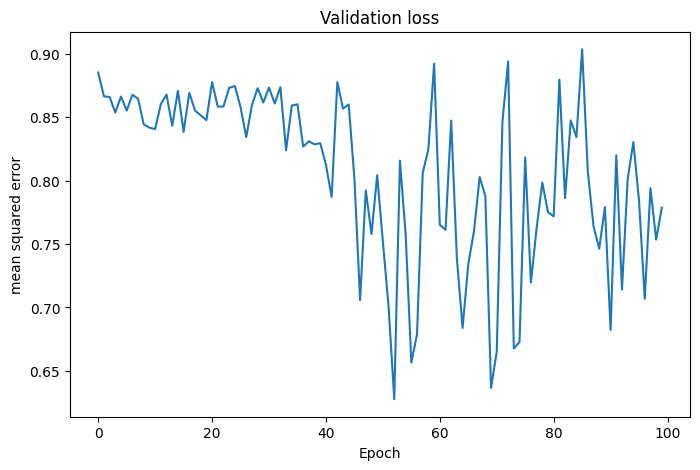

In [36]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 100
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('mean squared error')
plt.title('Validation loss')
plt.show()

In [37]:
with torch.no_grad():
    betas = estimator.get_betas(
        np.array(adata_train.obsm['spatial']),
        np.array(adata_train.obs['rctd_cluster']),
    )

    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(betas).cuda(), 
        torch.from_numpy(adata_train.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

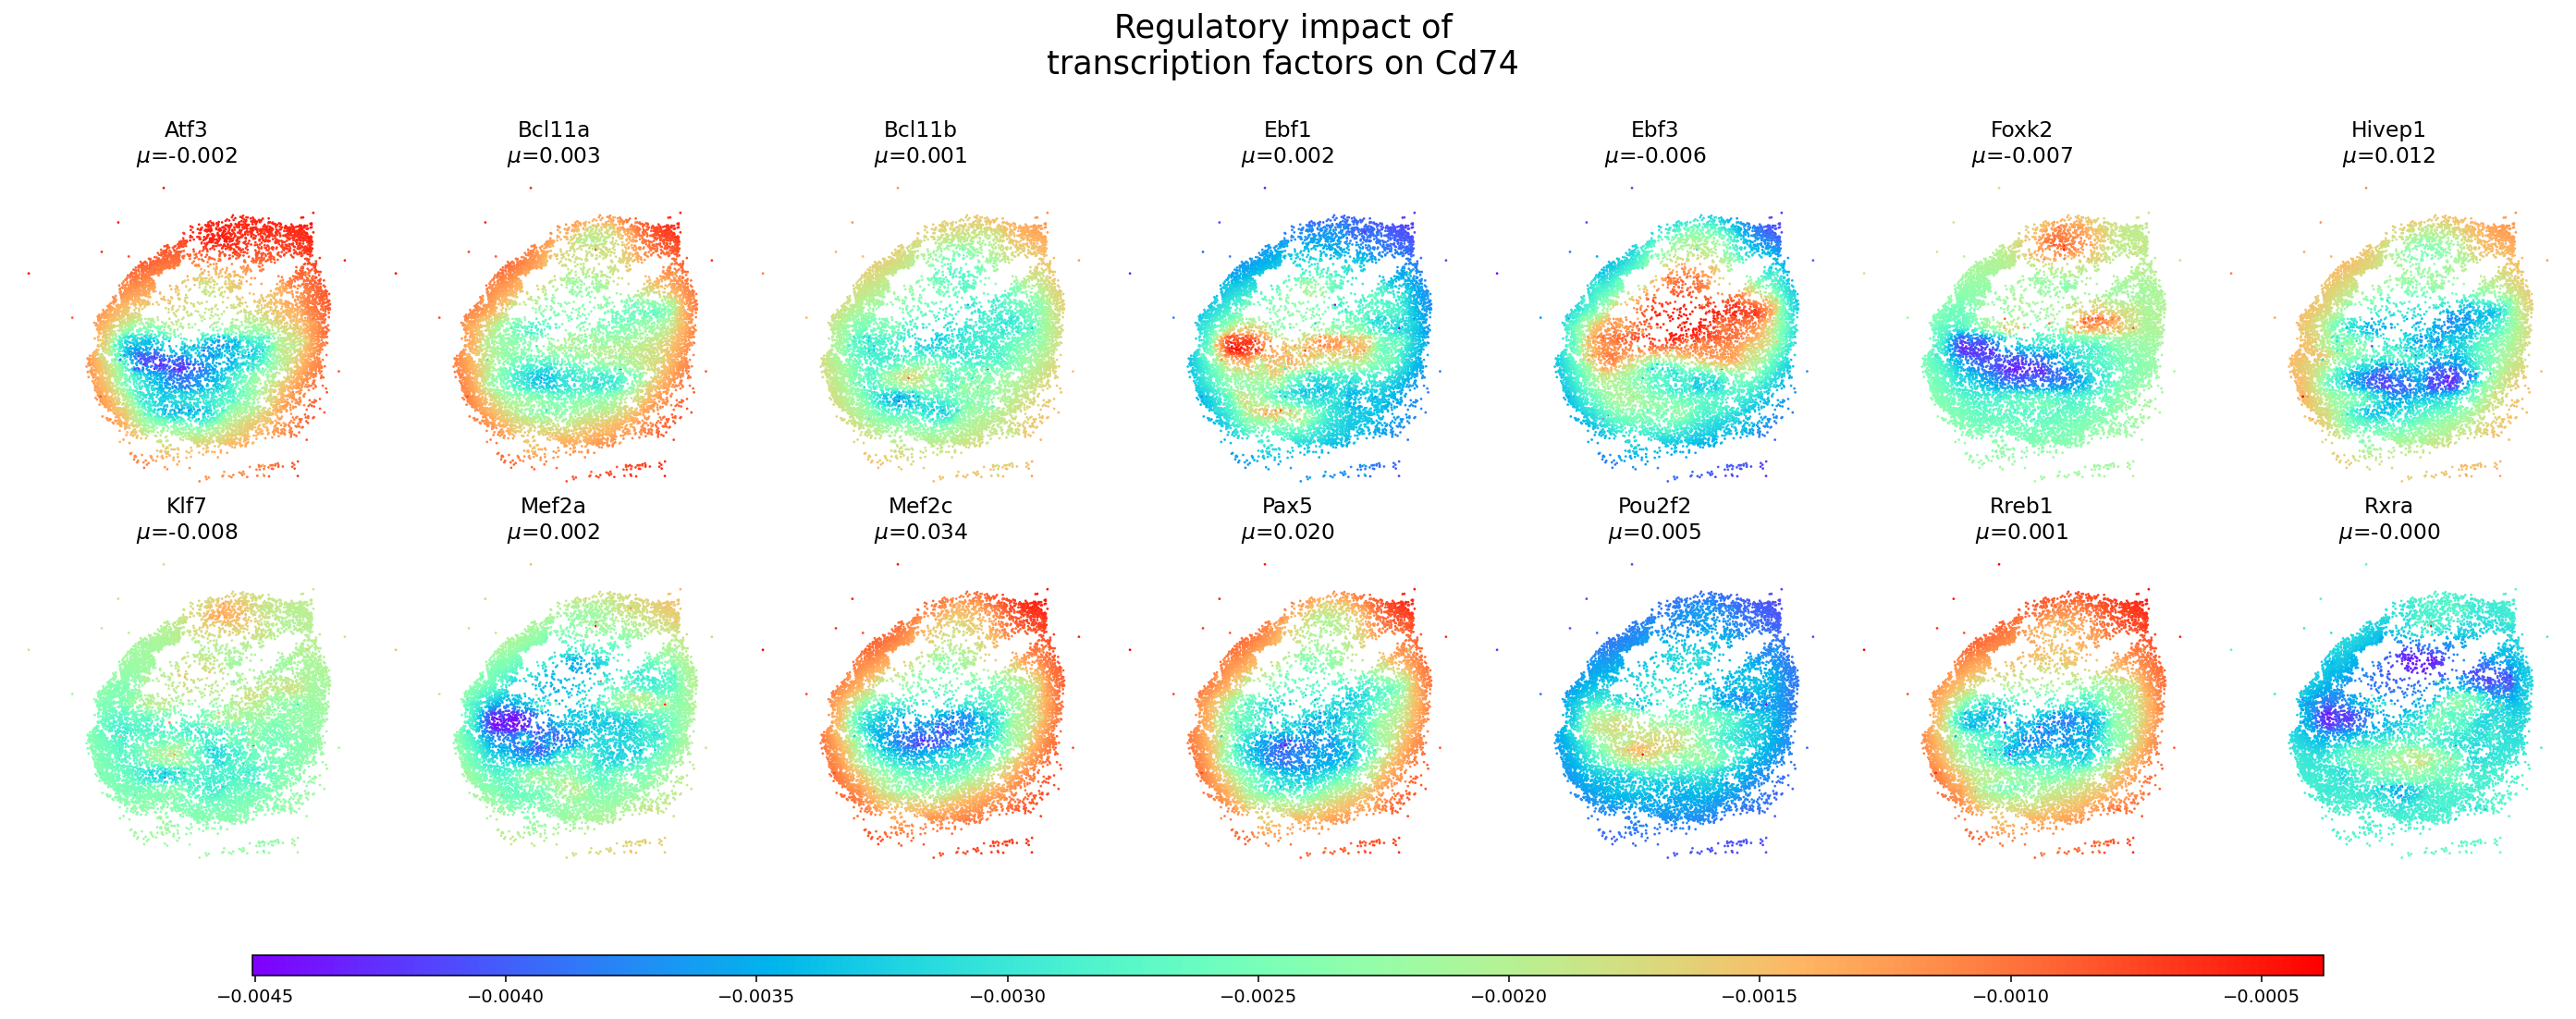

In [38]:
f, axs = plt.subplots(2, 7, figsize=(20, 8), dpi=140, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata_train.obsm['spatial'][:, 0], y=adata_train.obsm['spatial'][:, 1], 
                s=2, c=betas[:, i+1], cmap='rainbow', 
                ax=axs[i], edgecolor=None, linewidth=0, 
    )
    scatter_plots.append(scatter)

beta_means = list(betas.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{estimator.regulators[ix]}\n'+ r'$\mu$' + f'={beta_means[ix+1]:.3f}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.tight_layout()
f.subplots_adjust(bottom=0.15)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(
    scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')


plt.suptitle(f'Regulatory impact of \ntranscription factors on {estimator.target_gene} ', fontsize=18)
plt.subplots_adjust(top=0.825)

plt.show()

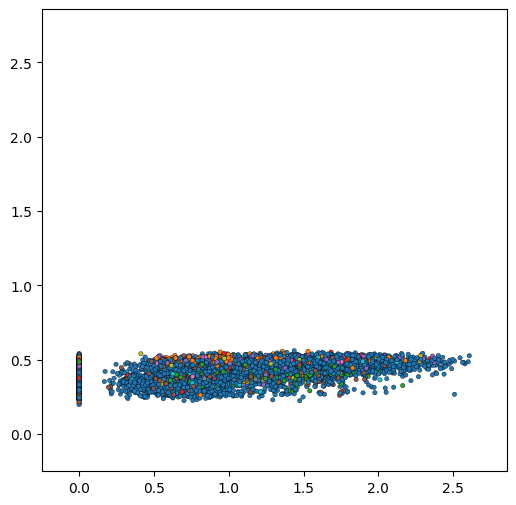

In [39]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = adata_train.to_df()[['Cd74']]
sns.scatterplot(
    x=y.values.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=adata_train.obs.cluster.values[:], cmap='tab10', edgecolor='black', linewidth=0.25)
plt.xlim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
plt.ylim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)

plt.show()

In [40]:
with torch.no_grad():
    betas_test = estimator.get_betas(
        np.array(adata_test.obsm['spatial']),
        np.array(adata_test.obs['rctd_cluster']),
    )
    
    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(betas_test).cuda(), 
        torch.from_numpy(adata_test.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

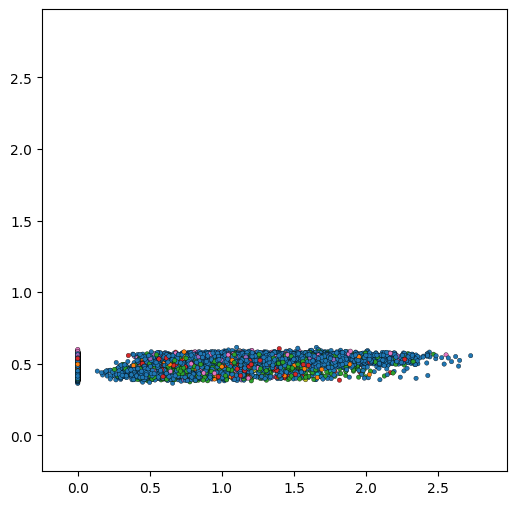

In [41]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = adata_test.to_df()[['Cd74']]
sns.scatterplot(
    x=y.values.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=adata_test.obs.cluster.values[:], cmap='tab10', edgecolor='black', linewidth=0.25)
plt.xlim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)
plt.ylim(y.values[:, :].min()-0.25, y.values[:, :].max()+0.25)

plt.show()



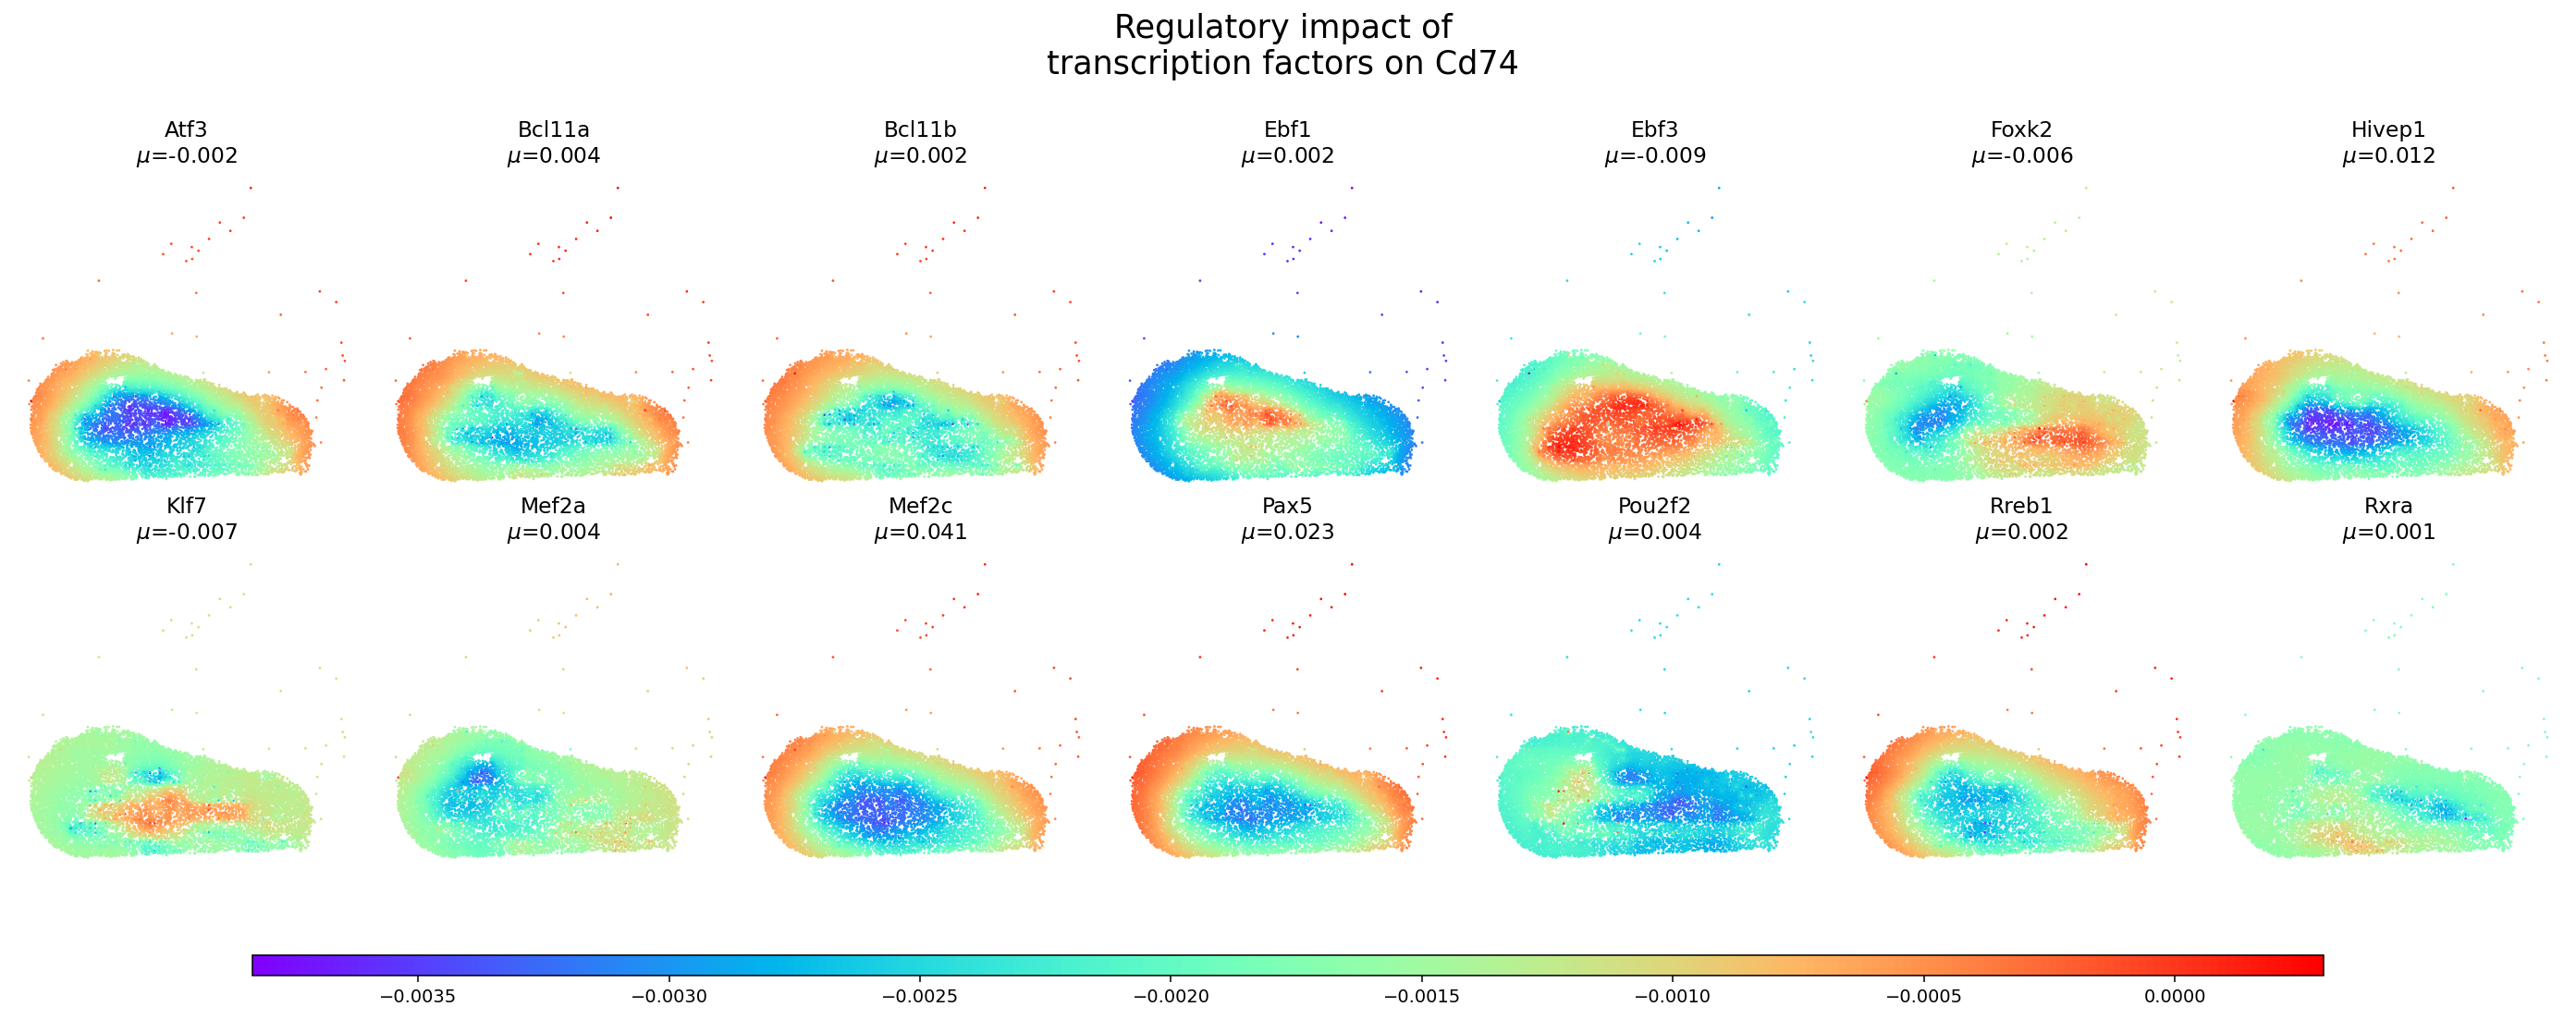

In [42]:
f, axs = plt.subplots(2, 7, figsize=(20, 8), dpi=140, sharex=True, sharey=True)
axs = axs.flatten()

scatter_plots = []

for i in range(len(axs)): 
    scatter = sns.scatterplot(x=adata_test.obsm['spatial'][:, 0], y=adata_test.obsm['spatial'][:, 1], 
                s=2, c=betas_test[:, i+1], cmap='rainbow', 
                ax=axs[i], edgecolor=None, linewidth=0, 
    )
    scatter_plots.append(scatter)

beta_means = list(betas_test.mean(0))
for ix, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'{estimator.regulators[ix]}\n'+ r'$\mu$' + f'={beta_means[ix+1]:.3f}')
    ax.set_xticks([])
    ax.set_yticks([])
    
    
plt.tight_layout()
f.subplots_adjust(bottom=0.15)

# Add a colorbar
cbar_ax = f.add_axes([0.1, 0.05, 0.8, 0.02])
colorbar = f.colorbar(
    scatter_plots[0].collections[0], cax=cbar_ax, orientation='horizontal')


plt.suptitle(f'Regulatory impact of \ntranscription factors on {estimator.target_gene} ', fontsize=18)
plt.subplots_adjust(top=0.825)

plt.show()

<AxesSubplot: title={'center': 'Pax5'}, xlabel='spatial1', ylabel='spatial2'>

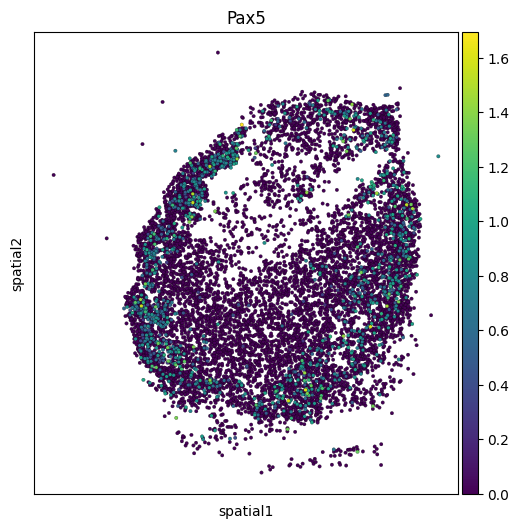

In [34]:
plt.rcParams['figure.dpi'] = 100
sc.pl.embedding(estimator.adata, color='Pax5', 
                basis="spatial", s=25, show=False, 
                edgecolor='black', linewidth=0.15)

In [46]:
# Examine attention weights

train_dataloader, valid_dataloader = estimator._build_dataloaders_from_adata(
    estimator.adata.copy(), estimator.target_gene, estimator.regulators, batch_size=1, mode='train', 
    rotate_maps=False, annot='rctd_cluster', spatial_dim=64)


for batch_spatial, batch_x, batch_y, batch_labels in valid_dataloader:
    break

In [47]:
att_weights = estimator.model.get_att_weights(batch_spatial.to('cuda'))
att_weights[0][0].shape # (nblocks, batch, nheads, patch, patch)

torch.Size([2, 257, 257])

In [48]:
n_blocks

2

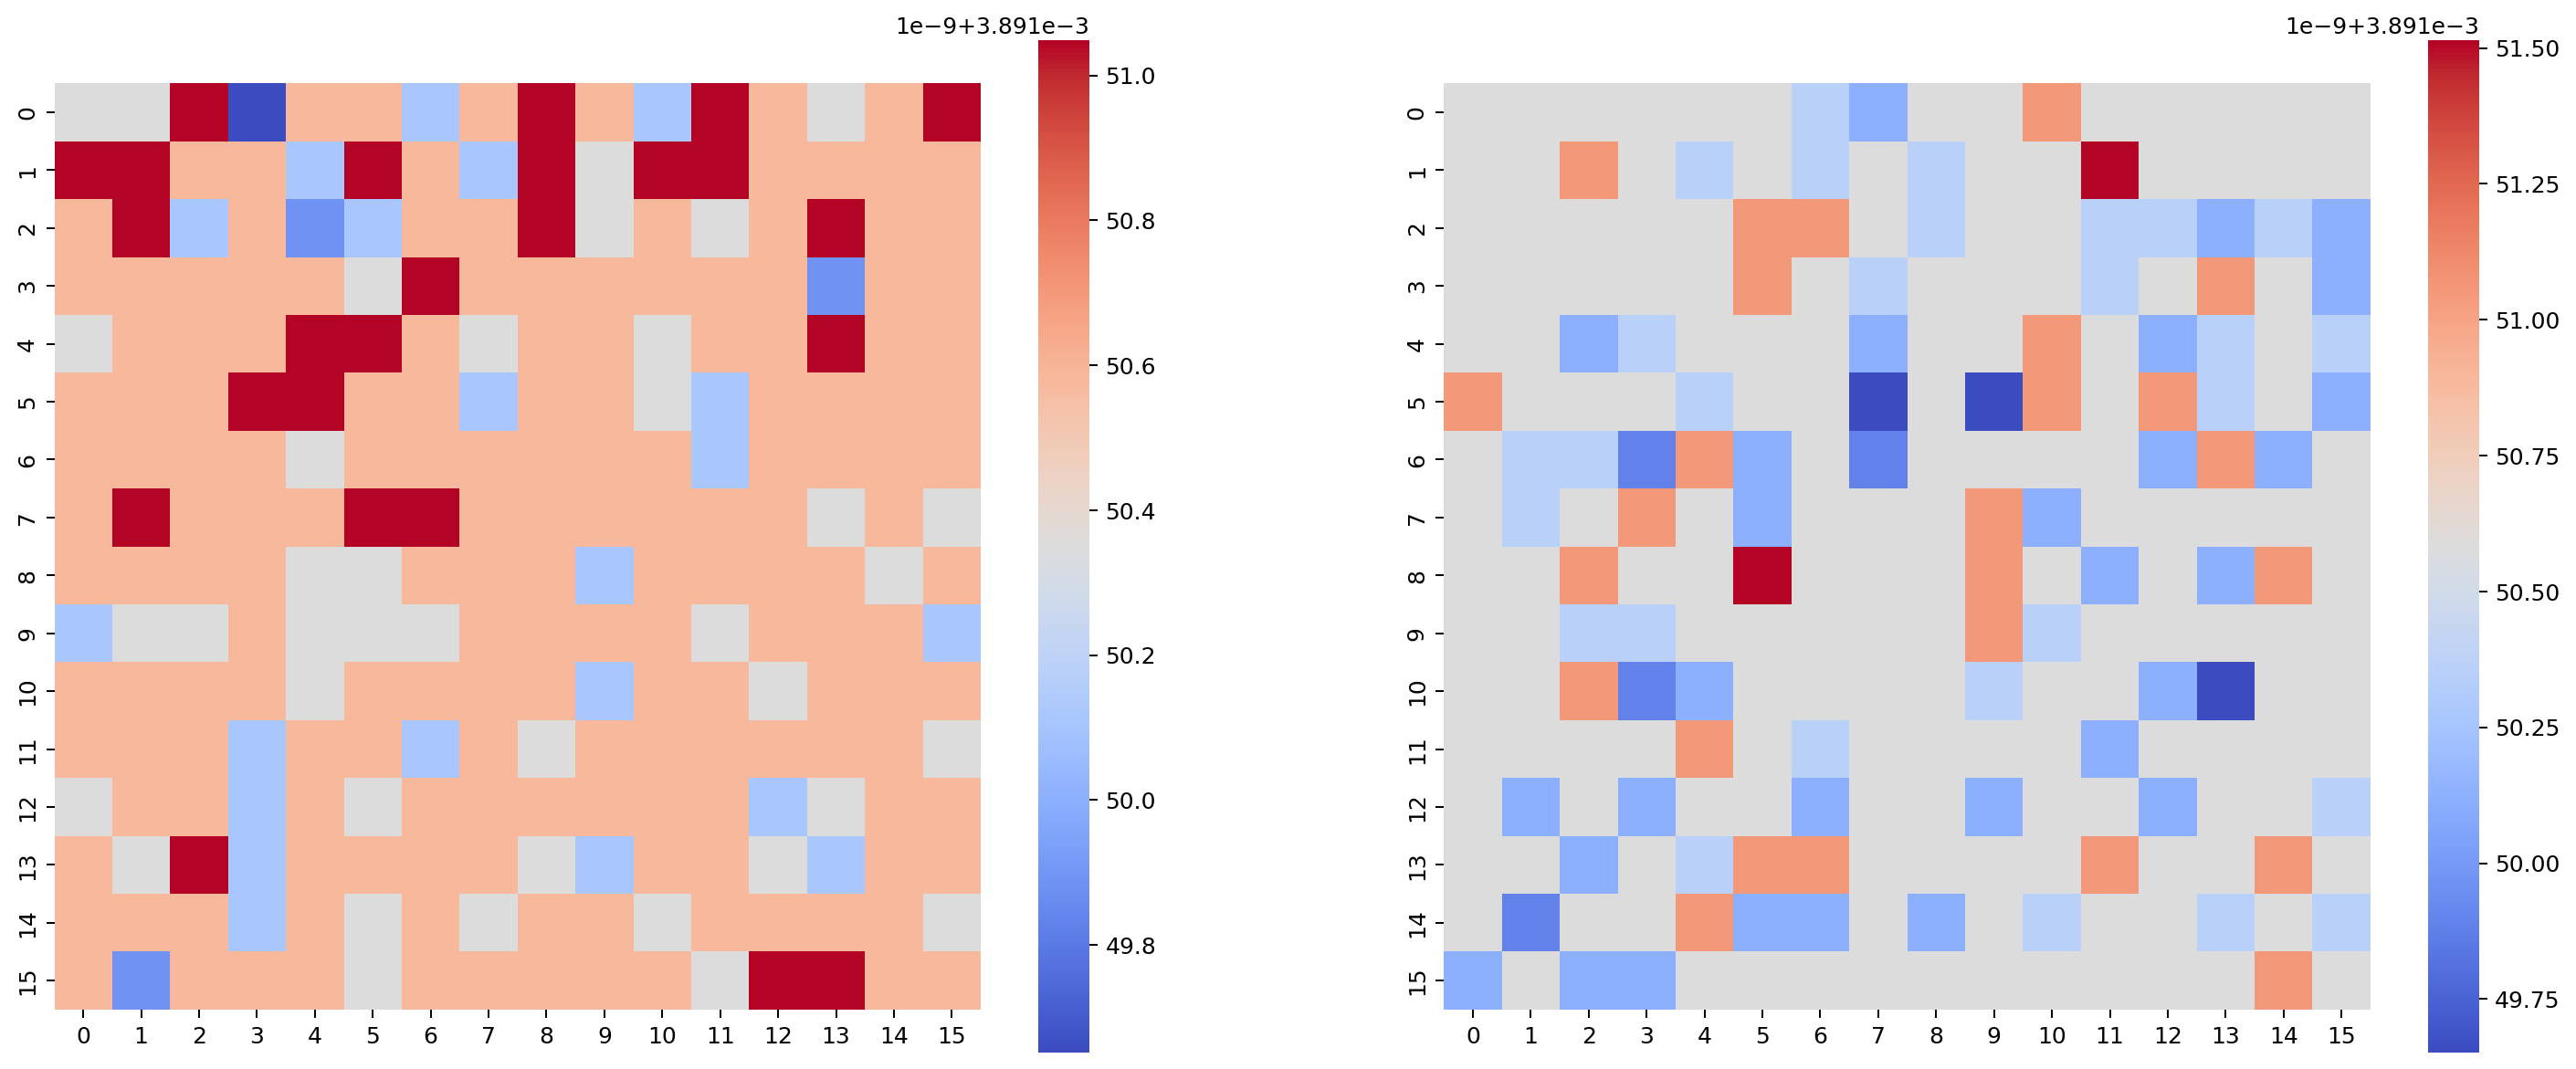

In [56]:
n_blocks = estimator.model.n_blocks
fig, axs = plt.subplots(ncols=n_blocks, figsize=(20, 8))

# (nblocks, batch, nheads, patch, patch)

for i in range(n_blocks):
    sns.heatmap(att_weights[1][0][i].mean(dim=1).squeeze(0).detach().cpu().numpy()[1:].reshape(16,16), 
                ax=axs[i], cmap='coolwarm', square=True)

<AxesSubplot: >

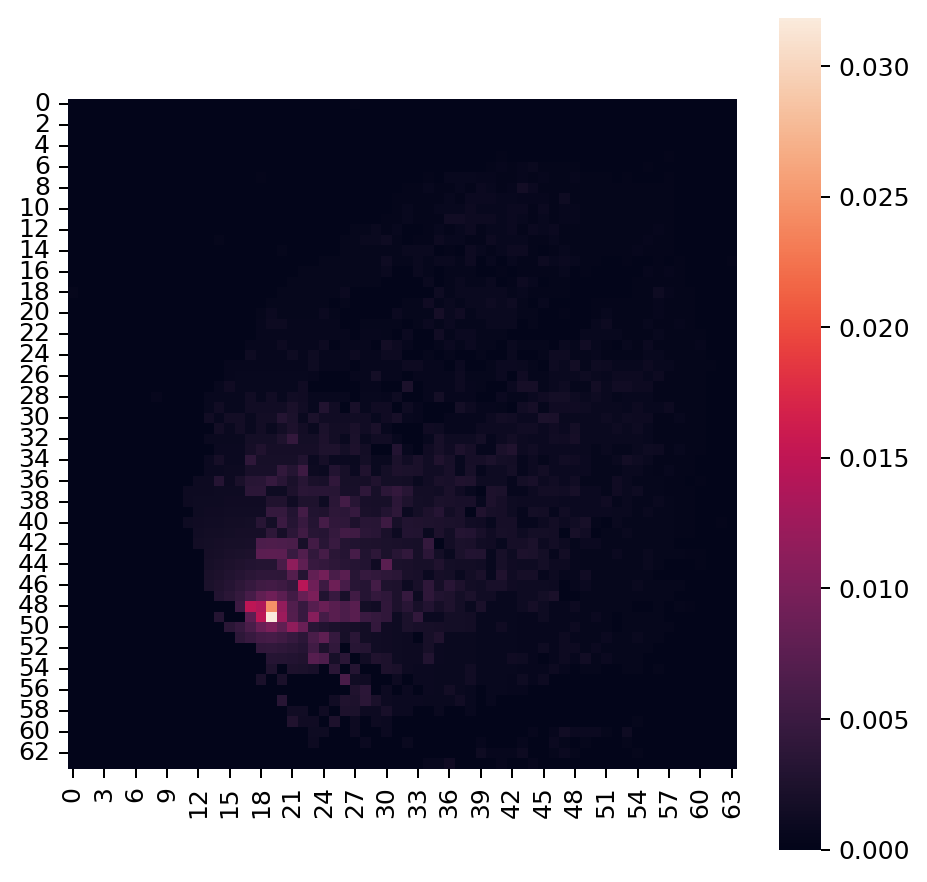

In [54]:
sns.heatmap(batch_spatial.sum(axis=1).squeeze().detach().cpu().numpy(), square=True)

In [39]:
r = torch.tensor([1, 2, 3, 4]).view(1, 4) @ torch.tensor([1, 2, 3, 4]).view(4, 1)
r.shape

torch.Size([1, 1])

In [ ]:
torch.tensor([1, 2, 3, 4]).view(1, 4) @ torch.tensor([1, 2, 3, 4]).view(4, 1)

In [68]:
B = torch.tensor([[1, 2, 3, 4]]*32).view(32, 4)

In [65]:
X = torch.tensor([[1, 2, 3, 4]]*32).view(32, 4)

In [75]:
X.unsqueeze(2).view(32, 1, 4).shape, B.unsqueeze(2).view(32, 4, 1).shape

(torch.Size([32, 1, 4]), torch.Size([32, 4, 1]))

In [77]:
torch.matmul(X.unsqueeze(2).view(32, 1, 4), B.unsqueeze(2).view(32, 4, 1))

tensor([[[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]],

        [[30]]])

In [59]:
# Reshape X and B to ensure they have compatible dimensions for matrix multiplication
X_reshaped = X.T.unsqueeze(0)  # Shape: (1, 4, 32)
B_reshaped = B.unsqueeze(0)    # Shape: (1, 4, 32)

# Perform matrix multiplication
result = torch.matmul(X_reshaped, B_reshaped.transpose(1, 2))

# Reshape the result to (1, 1)
result_reshaped = result.squeeze(0)  # Shape: (1, 1)

print(result_reshaped.shape)
print(result_reshaped)


torch.Size([4, 4])
tensor([[ 80,  80,  80,  80],
        [160, 160, 160, 160],
        [240, 240, 240, 240],
        [320, 320, 320, 320]])


In [55]:
(X @ B).shape

torch.Size([32, 32])

In [58]:
torch.matmul(X.T, B.T)

tensor([[ 80,  80,  80,  80],
        [160, 160, 160, 160],
        [240, 240, 240, 240],
        [320, 320, 320, 320]])

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate synthetic data
n_samples = 100
X = torch.linspace(0, 10, n_samples).unsqueeze(1)
true_weight = 2.5
true_bias = 1.0
y = true_weight * X + true_bias + torch.randn(n_samples, 1) * 0.5

# Initialize parameters
weight = torch.randn(1, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

# Define the model using torch.dot
def linear_regression(x):
    return torch.dot(x.squeeze(), weight) + bias

# Training loop
optimizer = torch.optim.SGD([weight, bias], lr=0.01)
n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    y_pred = linear_regression(X)
    
    # Compute loss
    loss = torch.mean((y_pred - y.squeeze())**2)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X.numpy(), y.numpy(), label='Ground Truth')
plt.plot(X.numpy(), linear_regression(X).detach().numpy(), color='r', label='Predicted')
plt.plot(X.numpy(), true_weight * X.numpy() + true_bias, color='g', linestyle='--', label='True Function')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression using PyTorch')
plt.legend()
plt.grid(True)
plt.show()

print(f"True weight: {true_weight}, Estimated weight: {weight.item():.4f}")
print(f"True bias: {true_bias}, Estimated bias: {bias.item():.4f}")


RuntimeError: inconsistent tensor size, expected tensor [100] and src [1] to have the same number of elements, but got 100 and 1 elements respectively